In [46]:
from qiskit import __version__
assert __version__ >= '2.0.0', f"Qiskit version must be grater than 2.0.0. Yours is: {__version__}"
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt

plt.style.use('dark_background')

# Using Surface Codes for error correction on qubits

A Quantum Computer is a machine that does error correction, any computation is incidental 

~ Andrew Steane

[Surface Code - Priceton](https://www.youtube.com/watch?v=BgmqtLQz27A&ab_channel=PrincetonCenterforComplexMaterials-PCCM)

Adiabatic rrors in a quantum machine can be modelled as Unitary operations on the blch sphere.

any error can be rappresented as $U = \alpha I + \beta \sigma_x + \gamma \sigma_y + \delta \sigma_z = \alpha I + \alpha X + \beta Y + \gamma Z$

since $Y \sim iXZ$, any unitary error can be expressed as a combination of X errors and Z errors

**An X Measurement:**

$X = \ket{+}\bra{+} - \ket{-}\bra{-}$

An X measurement is a measurement on the base $\{\ket{+}, \ket{-}\}$

it allow us to make a phase estimation of the state.

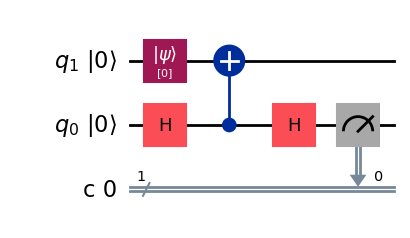

In [33]:
def phase_estimation(init_state)->QuantumCircuit:
    qr = QuantumRegister(2, 'q')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, cr)

    qc.initialize(init_state, qr[1], normalize=True)

    qc.h(qr[0])
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.measure(qr[0], cr[0])

    return qc

phase_estimation('0').draw('mpl', reverse_bits=True, initial_state=True)

This makes a non destructive measurement on the top qubit **q1**

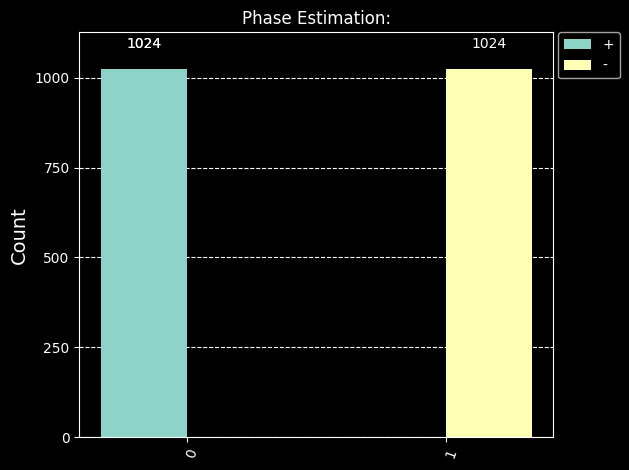

In [47]:
sim = AerSimulator(method='statevector')

states = [[1,1], [1, -1]]

qcs = [transpile(phase_estimation(state), sim) for state in states]
result = sim.run(qcs).result()
counts = result.get_counts()

plot_histogram(counts, title='Phase Estimation:', legend=['+', '-'])

$Z \otimes Z$ **Measurement**

This is a measurement of relative phase between two qbits

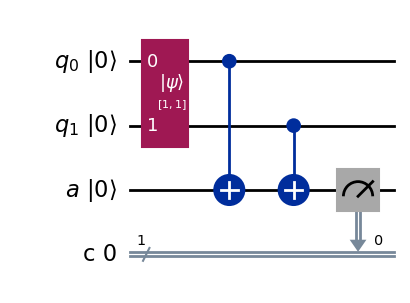

In [73]:
def ZZ_measurement(init_state)->QuantumCircuit:
    qr = QuantumRegister(2, 'q')
    ancilla = QuantumRegister(1, 'a')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.initialize(init_state, qr, normalize=True)

    qc.h(ancilla[0])
    qc.cz(ancilla[0], qr[0])
    qc.cz(ancilla[0], qr[1])
    qc.h(ancilla[0])

    qc.measure(ancilla[0], cr[0])

    return qc

def ZZ_measurement_eq(init_state)->QuantumCircuit:
    qr = QuantumRegister(2, 'q')
    ancilla = QuantumRegister(1, 'a')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.initialize(init_state, qr, normalize=True)

    qc.cx(qr[0], ancilla[0])
    qc.cx(qr[1], ancilla[0])

    qc.measure(ancilla[0], cr[0])

    return qc

ZZ_measurement_eq('11').draw('mpl', reverse_bits=False, initial_state=True)

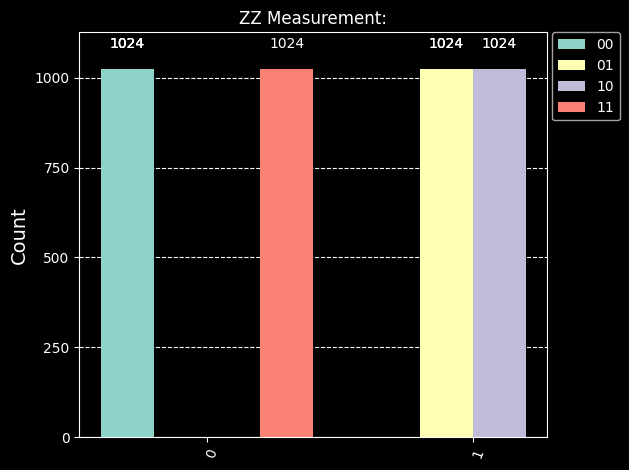

In [88]:
sim = AerSimulator(method='statevector')

states = ['00', '01', '10', '11']

qcs = [transpile(ZZ_measurement_eq(state), sim) for state in states]
result = sim.run(qcs).result()
counts = result.get_counts()

plot_histogram(counts, title='ZZ Measurement:', legend=states)

This measurement is equivalent to a Parity measurement on the two qubits.

## Stabilizers:

We ca use the stabilizer generators: $\{ Z \otimes Z \otimes  I, I \otimes Z \otimes Z \}$

to make the stabilizer: $<Z \otimes Z \otimes  I, I \otimes Z \otimes Z >  = \{ I \otimes I \otimes I, Z \otimes Z \otimes I, I \otimes Z \otimes Z, Z \otimes I \otimes Z \}$

**Bit Flip Detection**

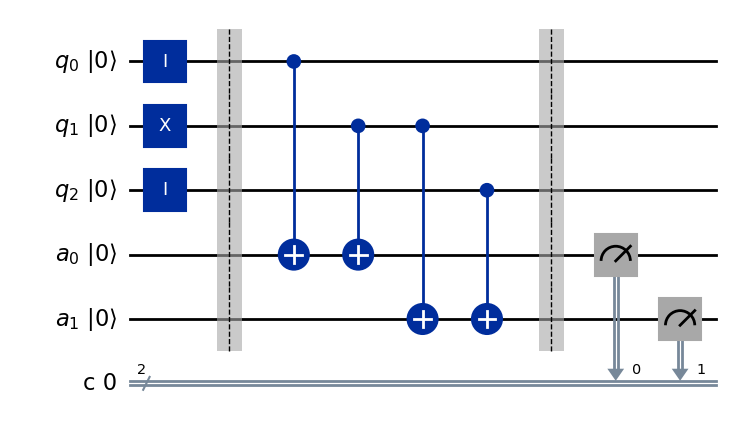

In [119]:
def bit_flip_err_detection(err_pos:int)->QuantumCircuit:

    qr = QuantumRegister(3, 'q')
    ancilla = QuantumRegister(2, 'a')
    cr = ClassicalRegister(2, 'c')

    qc = QuantumCircuit(qr, ancilla, cr)

    # apply bit flip error
    for i in range(3):
        if i == err_pos:
            qc.x(qr[i])
        else:
            qc.id(qr[i])

    qc.barrier()
    
    # apply error detection

    qc.cx(qr[0], ancilla[0])
    qc.cx(qr[1], ancilla[0])

    qc.cx(qr[1], ancilla[1])
    qc.cx(qr[2], ancilla[1])

    qc.barrier()

    qc.measure(ancilla[0], cr[0])
    qc.measure(ancilla[1], cr[1])
    
    return qc


bit_flip_err_detection(1).draw('mpl', reverse_bits=False, initial_state=True)

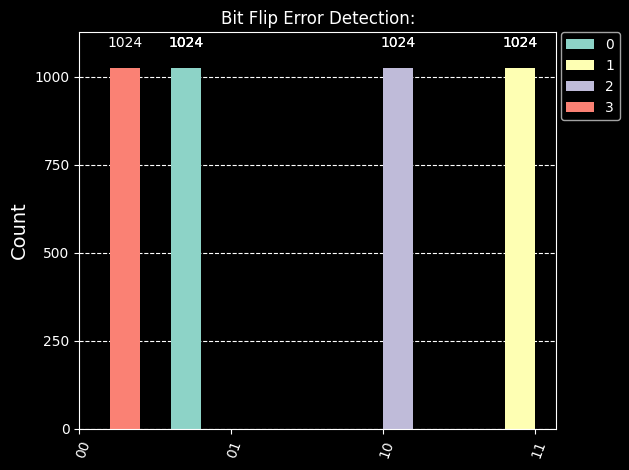

In [ ]:
sim = AerSimulator(method='statevector')

err_pos = [0, 1, 2, 3]
qcs = [transpile(bit_flip_err_detection(i), sim) for i in err_pos]
result = sim.run(qcs).result()
counts = result.get_counts()

plot_histogram(counts, title='Bit Flip Error Detection:', legend=[f"{i}" for i in err_pos])